# Hydrology with GRASS GIS

This is a quick introduction to common hydrologic workflows in *GRASS GIS* in *Jupyter Notebook*. In addition to common *Python* packages, it demonstrates the usage of `grass.script`, the *Python* API for GRASS GIS, and `grass.jupyter`, a *Jupyter Notebook* specific package that helps with the launch of *GRASS GIS* and with displaying maps. 

This interactive notebook is available online thanks to the [https://mybinder.org](Binder) service. To run the select part (called a *cell*), hit `Shift + Enter`.

WHAT DOES THIS NOTEBOOK DO?



## Starting GRASS in Jupyter Notebooks

In [8]:
# Import Python standard library and IPython packages we need.
import os
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("../../../grassdata", "nc_basic_spm_grass7", "user1")

# Set computational region to elevation raster
gs.run_command('g.region', raster='elevation@PERMANENT', flags='pg')

## Depression Filling?

## Computing Watersheds, Drainage Direction, Flow Accumulation, and Streams


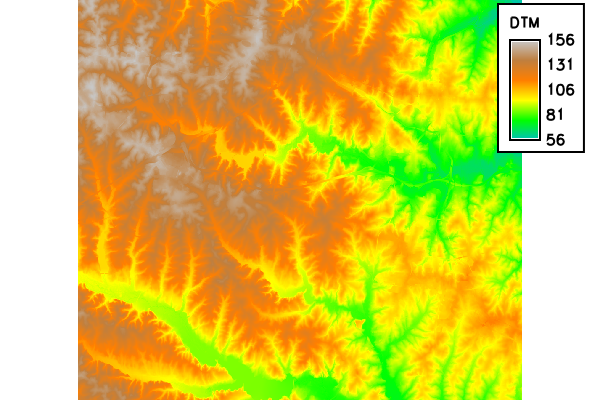

In [10]:
# First, let's view the elevation raster to get an overview of the area

# Start a GrassRenderer map
# GrassRenderer makes non-interactive maps using a PNG image
r = gj.GrassRenderer()

# Add a raster and vector to the map
gs.run_command('r.colors', map='elevation@PERMANENT', color='elevation')
r.d_rast(map='elevation@PERMANENT')
r.d_legend(raster="elevation@PERMANENT", at=(65, 90, 85, 90), fontsize=12, flags="b", title='DTM')

# Display map
r.show()

From the elevation raster, we compute the watersheds and display the results.

In [11]:
# Compute watersheds, drainage direction, flow accumulation, and streams

# r.watershed computes all of these
gs.run_command('r.watershed', 
               elevation='elevation@PERMANENT',
               drainage='drainage',    # Drainage Direction
               accumulation='flowacc', # Flow Accumulation
               basin='watersheds',
               stream='streams',
               threshold=100000)

# Convert streams raster to vector
gs.run_command('r.to.vect', input='streams', output='streams', type='line')

To view the results of 'r.watersheds', we'll use `grass.jupyter`'s `InteractiveMap` class which allows us to toggle between layers and zoom.

In [13]:
m = gj.InteractiveMap(height=400, width=600)

m.add_raster('elevation@PERMANENT')
m.add_raster('drainage')
m.add_raster('flowacc')
m.add_raster('watersheds')
m.add_vector('streams')

m.add_layer_control()

m.show()

ERROR: Raster map <drainage@PERMANENT> not found


CalledModuleError: Module run `r.proj -g input=drainage@user1 dbase=../../../grassdata location=nc_basic_spm_grass7` ended with an error.
The subprocess ended with a non-zero return code: 1. See errors above the traceback or in the error output.

## Watershed Area

With our watersheds, we can copute some zonal statistics. In this section, we use the "count" method in `r.stats.zonal` to make a map of watershed area.

In [ ]:
# Count cells in each watershed
gs.run_command('r.stats.zonal', base='watersheds', cover='elevation', method='count', output='watersheds_count')

# Get projection resolution
proj=gs.parse_command('g.region', flags='m')

# Multiply N-S resollution by E-W resolution to get cell area
cell_area = float(proj['nsres'])*float(proj['ewres'])

# Calculate watersheds areas and convert from m2 to km2
gs.mapcalc("'watershed_area' = float('watersheds_count'*{})/1000000".format(cell_area))

# Display a map of watershed areas. We'll use GrassRenderer here
gs.run_command('r.colors', map='watershed_area', color='plasma')

watershed_map = gj.GrassRenderer()
watershed_map.d_rast(map="watershed_area")
watershed_map.d_legend(raster='watershed_area',
                       bgcolor='none',
                       color='white',
                       border_color='none',
                       at=(3, 40, 84, 88),
                       lines=2,
                       fontsize=15,
                       title='Area',
                       units=' km2')
watershed_map.show()

## Estimating Inundation using HAND



In [ ]:
# We need to install the r.stream.distance addon for this
gs.run_command('g.extension', extension='r.stream.distance')

## Modeling Surface Water Flow



In [15]:
gs.run_command('r.slope.aspect', elevation='elevation', dx='dx', dy='dy')

gs.run_command('r.sim.water',
               elevation='elevation',
               dx='dx',
               dy='dy',
               rain_value=50,
               infil_value=0,
               man_value=0.05,
               depth='water_depth',
               discharge='discharge',
               nwalkers=80000,
               niterations=30)

In [16]:
m = gj.InteractiveMap(height=400, width=600)

m.add_raster('water_depth')

m.show()

ERROR: Raster map <water_depth@PERMANENT> not found


CalledModuleError: Module run `r.proj -g input=water_depth@user1 dbase=../../../grassdata location=nc_basic_spm_grass7` ended with an error.
The subprocess ended with a non-zero return code: 1. See errors above the traceback or in the error output.